# Dataset : https://www.kaggle.com/datasets/michaelarman/poemsdataset/data

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import numpy as np
from fastai.text.all import *

In [4]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

C:\Users\Yasmine\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yasmine\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

C:\Users\Yasmine\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
path = 'poemsdataset'

In [6]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 6322 poems in the dataset


In [7]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [8]:
txt = poems[0].open().read(); #read the first file
print(txt)

2 ABC of H.k. and China revised vision.
Barrels tears are wines and salts.
With a whisk on goody tails!
Wiggle maces to fix the heads.
Heads in jack on boxes are ceased.
Cry to paranoid truly bosses.
Bosses are jokers take your boys.
Studs are bogs with fire apples.
True predicates worth cases.â€™
Descents wash in badly bands.
Wholly sales are smart with cats.
Who got tenth honors in China?
Homage grand to play and plays!
Trim the times of hearts then cry.
Tanks in steels but voice wail.
Bossy dragged by tails that whisked.
Go very timid and love the wise.
Hands are lent but laws are ends.
Cases on courts are borrowed lands.
Length long with treads to retch!
Straps on times and watch here.
Arrays tanks but all are men.
Cross all suctions steal the ends.
Cave on minds are cages on objects.
Rouser rockets powers holes.
Confine curses to stop our wounds.
Whirl your bodies and jump on grounds.
Crouch of soldiers after kicks with flings.
Block one leg and hit the middle.
Cauchy3 know the tr

In [9]:
ballads = [open(o, encoding='utf-8').read() for o in ballads] # to make things easy we will gather all texts in one numpy array

In [10]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [11]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [12]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [13]:
show_at(tls.train, 0)

The burden of hard hitting. Slug away
Like Honus Wagner or like Tyrus Cobb.
Else fandom shouteth: "Who said you could play?
Back to the jasper league, you minor slob!"
Swat, hit, connect, line out, goet on the job.
Else you shall feel the brunt of fandom's ire
Biff, bang it, clout it, hit it on the knob -
This is the end of every fan's desire.
The burden of good pitching. Curved or straight.
Or in or out, or haply up or down,
To puzzle him that standeth by the plate,
To lessen, so to speak, his bat-renown:
Like Christy Mathewson or Miner Brown,
So pitch that every man can but admire
And offer you the freedom of the town -
This is the end of every fan's desire.
The burden of loud cheering. O the sounds!
The tumult and the shouting from the throats
Of forty thousand at the Polo Grounds
Sitting, ay, standing sans their hats and coats.
A mighty cheer that possibly denotes
That Cub or Pirate fat is in the fire;
Or, as H. James would say, We've got their goats -
This is the end of every fan'

In [14]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


In [15]:
dls.show_batch(max_n=2)

,text,text_
0,"I.\nThe death-bell beats!--\nThe mountain repeats\nThe echoing sound of the knell;\nAnd the dark Monk now\nWraps the cowl round his brow,\nAs he sits in his lonely cell.\nII.\nAnd the cold hand of death\nChills his shuddering breath,\nAs he lists to the fearful lay\nWhich the ghosts of the sky,\nAs they sweep wildly by,\nSing to departed day.\nAnd they sing of the hour\nWhen the stern fates had power\nTo resolve Rosa’s form to its clay.\nIII.\nBut that hour is past;\nAnd that hour was the last\nOf peace to the dark Monk’s brain.\nBitter tears, from his eyes, gushed silent and fast;\nAnd he strove to suppress them in vain.\nIV.\nThen his fair cross of gold he dashed on the floor,\nWhen the death-knell struck on his ear.--\n'Delight is in store\nFor her evermore;\nBut for me is fate, horror, and fear.'\nV.\nThen his eyes wildly rolled,\nWhen the death-bell tolled,\nAnd he raged in terrific woe",".\nThe death-bell beats!--\nThe mountain repeats\nThe echoing sound of the knell;\nAnd the dark Monk now\nWraps the cowl round his brow,\nAs he sits in his lonely cell.\nII.\nAnd the cold hand of death\nChills his shuddering breath,\nAs he lists to the fearful lay\nWhich the ghosts of the sky,\nAs they sweep wildly by,\nSing to departed day.\nAnd they sing of the hour\nWhen the stern fates had power\nTo resolve Rosa’s form to its clay.\nIII.\nBut that hour is past;\nAnd that hour was the last\nOf peace to the dark Monk’s brain.\nBitter tears, from his eyes, gushed silent and fast;\nAnd he strove to suppress them in vain.\nIV.\nThen his fair cross of gold he dashed on the floor,\nWhen the death-knell struck on his ear.--\n'Delight is in store\nFor her evermore;\nBut for me is fate, horror, and fear.'\nV.\nThen his eyes wildly rolled,\nWhen the death-bell tolled,\nAnd he raged in terrific woe."
1,"John Barleycorn got up again,\nAnd sore surpris'd them all.\nThe sultry suns of Summer came,\nAnd he grew thick and strong;\nHis head weel arm'd wi' pointed spears,\nThat no one should him wrong.\nThe sober Autumn enter'd mild,\nWhen he grew wan and pale;\nHis bending joints and drooping head\nShow'd he bagan to fail.\nHis colour sicken'd more and more,\nHe faded into age;\nAnd then his enemies began\nTo show their deadly rage.\nThey've taen a weapon, long and sharp,\nAnd cut him by the knee;\nThen tied him fast upon a cart,\nLike a rogue for forgerie.\nThey laid him down upon his back,\nAnd cudgell'd him full sore;\nThey hung him up before the storm,\nAnd turn'd him o'er and o'er.\nThey filled up a darksome pit\nWith water to the brim;\nThey heaved in John Barleycorn,\nThere let him sink or swim.\nThey laid him out upon the floor,\nTo work him further woe;\nAnd still, as signs of","Barleycorn got up again,\nAnd sore surpris'd them all.\nThe sultry suns of Summer came,\nAnd he grew thick and strong;\nHis head weel arm'd wi' pointed spears,\nThat no one should him wrong.\nThe sober Autumn enter'd mild,\nWhen he grew wan and pale;\nHis bending joints and drooping head\nShow'd he bagan to fail.\nHis colour sicken'd more and more,\nHe faded into age;\nAnd then his enemies began\nTo show their deadly rage.\nThey've taen a weapon, long and sharp,\nAnd cut him by the knee;\nThen tied him fast upon a cart,\nLike a rogue for forgerie.\nThey laid him down upon his back,\nAnd cudgell'd him full sore;\nThey hung him up before the storm,\nAnd turn'd him o'er and o'er.\nThey filled up a darksome pit\nWith water to the brim;\nThey heaved in John Barleycorn,\nThere let him sink or swim.\nThey laid him out upon the floor,\nTo work him further woe;\nAnd still, as signs of life"


In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [18]:
learn.validate()

C:\Users\Yasmine\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\Yasmine\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


(#2) [4.1808180809021,65.41934967041016]

SuggestedLRs(valley=7.585775892948732e-05)

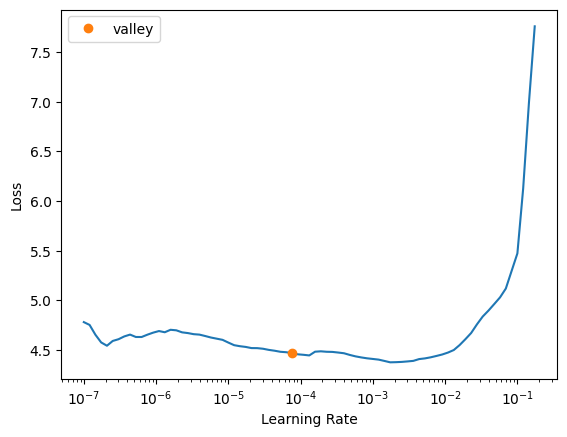

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.359070,4.000042,54.600441,16:55


# Poem Generation Example

In [22]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = torch.tensor(prompt_ids)[None]
inp.shape

torch.Size([1, 3])

In [27]:
preds = learn.model.generate(prompt_ids, 
                       max_length=100, 
                       num_beams=5, 
                       no_repeat_ngram_size=2, 
                       early_stopping=True,
                       pad_token_id=pad_token_id,
                       attention_mask=attention_mask)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
love is ridiculous."
"I don't know what to do with you," he said, "but I'll tell you what I think of you. I've never seen you like this before, and I'm afraid you'll never see me again. Don't you think I'd like to see you again?"
He shook his head. "Don't be afraid of me," said he; "I'll be glad to meet you in person, if you're willing to listen to me."


In [36]:
prompt = "cats are cute"
prompt_ids = tokenizer.encode(prompt)
inp = torch.tensor(prompt_ids)[None]
preds = learn.model.generate(inp, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=pad_token_id, attention_mask=attention_mask)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
cats are cute, but they don't have to be.
I've seen a lot of them in my life, and I've never seen one that I'd like to see again. I'm not sure if I'll ever see them again, or if they'll be a part of my family. But I know they've been around for a long time, so I can't wait to find out what they're up to. And I hope you'll join me on the hunt for them.
